# Gradient Angle based approach

Instead of just using an edge map, we'll use an edge map with a gradient angle map to inform our hough transform.
Along the way, we notice we could even take subsets of the histogram of the gradient angles to slice out the lines associated mostly with the chessboards.

Populating the interactive namespace from numpy and matplotlib
Image size 768x576


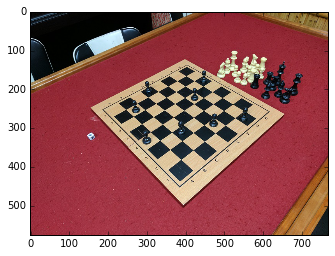

In [183]:
%pylab inline
from IPython.display import Image, display
import PIL.Image
import matplotlib.image as mpimg
import scipy.ndimage
import cv2 # For Sobel etc
np.set_printoptions(suppress=True) # Better printing of arrays
plt.rcParams['image.cmap'] = 'jet' # Default colormap is jet

filename = "6.jpg"
# img_orig = mpimg.imread(filename)
img_orig = PIL.Image.open(filename)
img_width, img_height = img_orig.size
print("Image size %dx%d" % (img_width, img_height))

aspect_ratio = min(1000/img_width, 800/img_height)
if aspect_ratio < 1.0:
    new_width, new_height = ((np.array(img_orig.size) * aspect_ratio)).astype(int)
    print(" Resizing to %dx%d" % (new_width, new_height))
    img_orig = img_orig.resize((new_width,new_height))


img = np.array(img_orig.convert('L')) # grayscale uint8 numpy array

plt.imshow(img_orig);

In [184]:
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

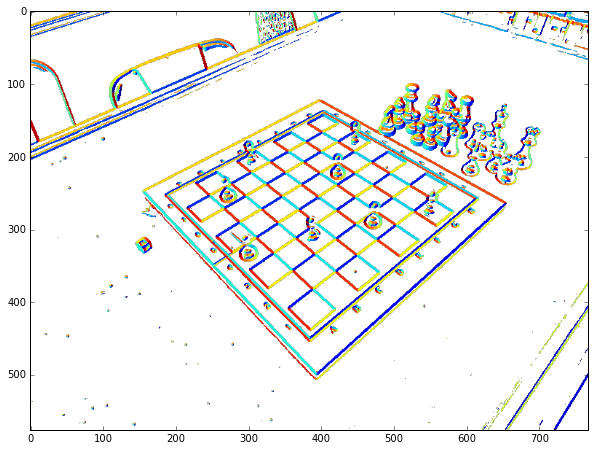

In [185]:
grad_mag = np.sqrt(sobelx**2+sobely**2)
grad_phase = np.arctan2(sobely, sobelx) # from -pi to pi

# Remove phase from where gradient magnitude is less than the mean * constant
grad_phase_masked = grad_phase.copy()
gradient_mask_threshold = 2*np.mean(grad_mag.flatten())
grad_phase_masked[grad_mag < gradient_mask_threshold] = np.nan

fig = plt.figure(figsize=(10,10))
plt.imshow(grad_phase_masked);

We'll also get an edge map from the image, which we'll use as an input to the informed hough transform


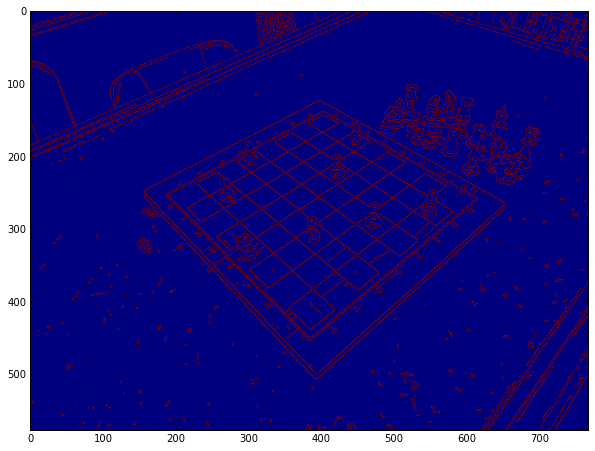

In [186]:
fig = plt.figure(figsize=(10,10))
edges = cv2.Canny(np.uint8(img),50,150,apertureSize = 3)
plt.imshow(edges);

The naive hough transform introduces a lot of spurious lines over the image, making it difficult to find the right one.

# Informed Hough Transform
Take the hough transform, but instead we severely limit the angles splatted to as a function of the estimated angle. 

We should also weight by the gradient magnitude

In [187]:
def informedHough(bin_img, gradient_phase_img, gradient_magnitude_img, theta_bin_size=100, rho_bin_size=100, inform_range=5):
    """Return informed hough space of input binary image"""
    thetas = np.linspace(0,np.pi,theta_bin_size)
    rho_diagonal = np.sqrt(np.sum(np.array(bin_img.shape)**2))
    rhos = np.linspace(-rho_diagonal,rho_diagonal,rho_bin_size) # length of diagonal
    hough_space = np.zeros([theta_bin_size, rho_bin_size])

    for i in range(bin_img.shape[0]):
        for j in range(bin_img.shape[1]):
            g = gradient_phase_img[i,j]
            if bin_img[i,j] and not np.isnan(g):
                if g < 0:
                    g += np.pi # + 180 degrees
                # Get informed theta range
                theta_idx = np.searchsorted(thetas, g) # Get bin index in thetas
                theta_left = max(0,theta_idx - inform_range)
                theta_right = min(len(thetas)-1,theta_idx + inform_range)
                
                # Over the informed theta sweep range
                for t,theta in enumerate(thetas[theta_left:theta_right]):
                    # TODO continue to use %prun and see if building a cos/sin table is valuable
                    rho = j*np.cos(theta) + i*np.sin(theta)
                    rho_idx = np.searchsorted(rhos, rho) # Get bin index for rhos
                    hough_space[theta_idx-inform_range+t, rho_idx] += gradient_magnitude_img[i,j] # Add gradient magnitude
    return (hough_space, thetas, rhos)

Do the informed hough transform

In [188]:
%%time
h2, thetas, rhos = informedHough(edges, grad_phase_masked, grad_mag, theta_bin_size=4*360, rho_bin_size=4*360, inform_range=10)

Wall time: 4.11 s


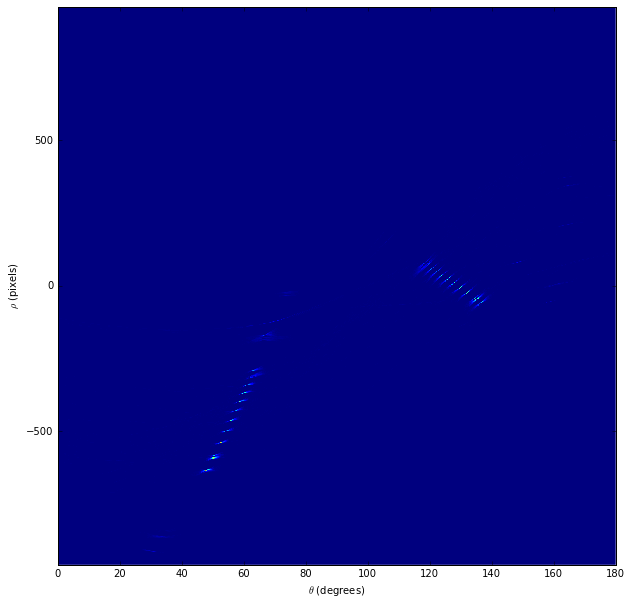

In [189]:
fig = plt.figure(figsize=(10,10))
plt.imshow(h2.T, interpolation='none', extent=[thetas[0]*180/np.pi, thetas[-1]*180/np.pi, rhos[0], rhos[-1]], cmap=cm.jet)
plt.xlabel(r'$\theta}$ (degrees)')
plt.ylabel(r'$\rho}$ (pixels)')
plt.axis('normal')
plt.axis('tight');

We can limit theta to positive values (0 to pi) to keep reflections showing up (such as a 45 degree line vs a 225/-135 degree line with inverted rhos), but in this case rho can go negative.

This works *much* better than a niave hough transform, heavily reducing the number of superfluous points. The chessboard lines show up clearly as sets of points in a line. Now we just need to find those peaks.

## Hough Peak Detection
Initially I started with just detecting max values and trying to mask out the region once found, unfortunately the values just beyond the edge of the mask tended to be higher than other peaks, causing the found peaks to be points that stair step along to the strongest peak only.

Another approach is to instead suppress all values where within it's neighborhood there is a stronger value. After an initial run with manual code, we optimize for wrapping around edges using scipy's generic_filter.

In [190]:
def doThing(neighborhood,center_idx):
    # Definitely not if no hits to hough at this point
    center_val = neighborhood[center_idx]
    if (center_val == 0):
        return False
    neighborhood[center_idx] = 0 # Don't compare to self
    return not np.any(neighborhood >= center_val)

def getLocalMaxArray(h,winsize=7):
    """Returns matrix with only the peaks of a given input matrix"""
    # winsize needs to be odd to choose center_idx correctly
    center_idx =(winsize+1)*(winsize >> 1)
    return scipy.ndimage.generic_filter(h,
                                        doThing,
                                        size=winsize,
                                        mode='wrap',
                                        extra_arguments=(center_idx,)).astype(bool)


In [191]:
%%time
input_h = h2.copy()
# Generate peak image
is_peak = getLocalMaxArray(input_h, winsize=11)
local_max_img = input_h.copy() 
local_max_img[~is_peak] = 0 # Set peaks with intensity of peak

# fig = plt.figure(figsi ze=(5,5))
# plt.imshow(local_max_img.T > 0, interpolation='none', cmap=cm.inferno);

Wall time: 4.27 s


Now that we have a suppressed hough image with only the peaks showing, we find the peak points and sort them in order of strongest to weakest.

Found 676 peaks, 30 strong peaks, keeping only the first 30


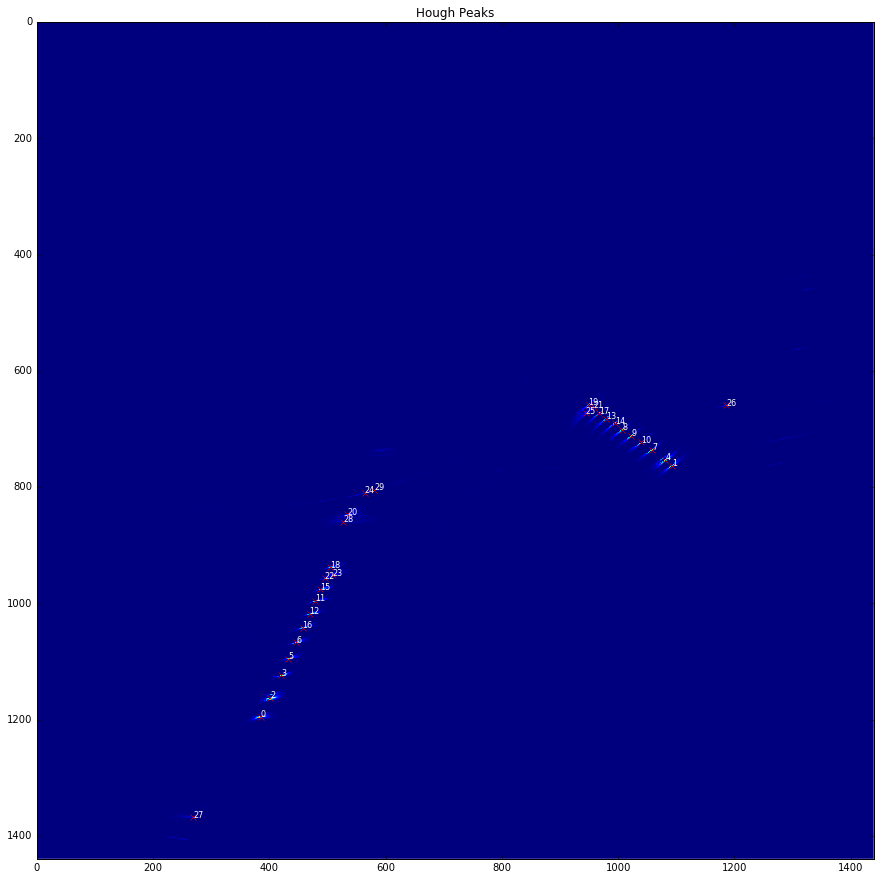

In [192]:
# local_max_img[local_max_img<100000] = 0
peaks = np.argwhere(local_max_img)

peak_mags = local_max_img[peaks[:,0],peaks[:,1]]
peak_order = np.argsort(peak_mags)[::-1] # Strongest to weakest

# Sort peaks by strength
peaks = peaks[peak_order,:]
peak_mags = peak_mags[peak_order]

fig = plt.figure(figsize=(15,15))

# Only want peaks that are within half a standard deviation of the mean
threshold_good_peak = peak_mags.mean() + peak_mags.std()/2
n_good_peaks = peaks.shape[0] - np.searchsorted(peak_mags[::-1], threshold_good_peak)

n_peaks = min(n_good_peaks,100)
print("Found",peaks.shape[0],"peaks,",
      n_good_peaks,"strong peaks, keeping only the first",n_peaks)


plt.imshow(input_h.T, interpolation='none')
plt.plot(peaks[:n_peaks,0], peaks[:n_peaks, 1], 'xr')
for idx, [px, py] in enumerate(peaks[:n_peaks,:]):
    plt.text(px, py,'%s' % idx, color='white', size=8)
plt.axis('normal')
plt.axis('tight')
plt.title('Hough Peaks');

Now the slightly obnoxious calculation of the line segments within the image bounds from the given theta/rho pairs from the best lines that are the peaks.

In [193]:
def getHoughLines(peaks, thetas, rhos, img_shape):
    # lines segments within image bounds x1 y1 x2 y2
    lines = np.zeros([peaks.shape[0],4])
    
    for i, [theta_, rho_] in enumerate(peaks):
        theta = thetas[theta_]
        rho = rhos[rho_]
        c = np.cos(theta)
        s = np.sin(theta)
        
        img_x_max = img_shape[1]-1
        img_y_max = img_shape[0]-1
#         print("sin:",s)
#         print("cos:",c)
#         print(theta*180/np.pi,rho)

        if np.abs(c) < np.abs(s):
            # angle is closer to 0 or 180 degrees, horizontal line so use x limits
#             print("H")
            x1 = 0
            x2 = img_x_max
            y1 = (rho - x1*c)/s
            y2 = (rho - x2*c)/s
        else:
            # angle closer to 90 degrees, vertical line so use y limits
#             print("V")
            y1 = 0
            y2 = img_y_max
            x1 = (rho - y1*s)/c
            x2 = (rho - y2*s)/c
        
#         print(x1, y1, x2, y2)

        # Get line ends within image bounds
        # TODO : Fails on very close to vertical/horizontal lines due to divide by ~zero
        if (np.abs(s) > 0.01 and np.abs(c) > 0.01):
            if (y1 < 0):
                x1 = (rho - 0*s)/c
                y1 = (rho - x1*c)/s
            elif (y1 > img_y_max):
                x1 = (rho - img_y_max*s)/c
                y1 = (rho - x1*c)/s
            if (y2 < 0):
                x2 = (rho - 0*s)/c
                y2 = (rho - x2*c)/s
            elif (y2 > img_y_max):
                x2 = (rho - img_y_max*s)/c
                y2 = (rho - x2*c)/s

            if (x1 < 0):
                y1 = (rho-0*c)/s
                x1 = (rho - y1*s)/c
            elif (x1 > img_x_max):
                y1 = (rho - img_x_max*c)/s
                x1 = (rho - y1*s)/c
            if (x2 < 0):
                y2 = (rho-0*c)/s
                x2 = (rho - y2*s)/c
            elif (x2 > img_x_max):
                y2 = (rho - img_x_max*c)/s
                x2 = (rho - y2*s)/c

        lines[i,:] = [x1, y1, x2, y2]

    return lines

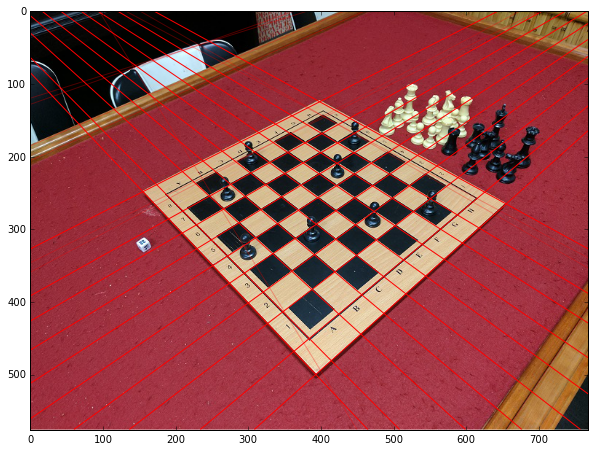

In [194]:
fig = plt.figure(figsize=(10,10))
plt.imshow(img_orig);
plt.axis([0,img.shape[1],img.shape[0],0])

lines = getHoughLines(peaks[:n_peaks], thetas, rhos, img.shape)

for i, [x1,y1,x2,y2] in enumerate(lines):
    alpha_ = 1.0 if i < min(peaks.shape[0],20) else 0.3 # Make first 20 lines strongest
    plt.plot([x1,x2], [y1,y2],'r-', alpha=alpha_, lw=1)

# Filter down to internal chessboard lines
Now we can narrow down which lines are internal chessboard lines by check the alternating nature of gradient phases (a sharp bimodal distribution essentially), which is what the checkboard pattern of most chessboard will result in. This won't work well/at all with chessboards that have thick solid lines delineating the checkerboard pattern, but we'll cross that bridge another day.

In [195]:
def getLineGradients(line, gradient_x, gradient_y, sampling_rate=1):
    """Calculate normal gradient values along line given x/y gradients and a line segment."""
    
    # 1 - Get gradient values
    line = np.array(line)
    ptA = line[:2]
    ptB = line[2:]
    
    # unit vector in direction of line
    line_length = np.linalg.norm(ptB - ptA)
    line_direction = (ptB - ptA) / line_length
    
    # Convert to normal
    line_normal = np.array([-line_direction[1], line_direction[0]]) # -y, x for normal in one direction
    line_angle = np.math.atan2(line_normal[1], line_normal[0])

    # Get points along line, choosing number of points giving a sampling rate in pixels per points (1-1 is good)
    num_pts_on_line = np.ceil(np.sqrt(np.sum((ptB - ptA)**2)) / sampling_rate)
    guessx = np.linspace(ptA[1],ptB[1],num_pts_on_line)
    guessy = np.linspace(ptA[0],ptB[0],num_pts_on_line)
    
    line_indices = np.floor(np.vstack((guessx, guessy)).T).astype(int)
    gradients = np.vstack(
            [gradient_x[line_indices[:,0], line_indices[:,1]],
             gradient_y[line_indices[:,0], line_indices[:,1]]])
    
    # Normalize the gradients before dotting
#     gradients /= np.sqrt(np.sum(gradients**2,axis=0))
#     gradients[np.isnan(gradients)] = 0
#     print(gradients.T)
    
    # Magnitude of gradient along normal
    normal_gradients = line_normal.dot(gradients)
    
    # Smooth it with a mean
#     normal_gradients = scipy.ndimage.generic_filter(normal_gradients, np.mean, size=(10))
    
    # Calculate fft, since sampling rate is static, we can just use indices as a comparison method
    fft_result = np.abs(np.fft.rfft(normal_gradients).real)
    
    strongest_freq = np.argmax(fft_result)
    
    return strongest_freq, normal_gradients, fft_result, line_angle
    
def angleClose(a, b, angle_threshold=10*np.pi/180):
    d = np.abs(a - b)
    return d < angle_threshold or np.abs(2*np.pi-d) < angle_threshold # Handle around the edge

def segmentAngles(angles, good_mask, angle_threshold=10*np.pi/180):
    # Partition lines based on similar angles int segments/groups
    good = np.zeros(freqs.shape,dtype=bool)
    segment_mask = np.zeros(angles.shape, dtype=int)
    
    segment_idx = 1
    for i in range(angles.size):
        # Skip if not a good line or line already grouped
        if not good_mask[i] or segment_mask[i] != 0:
            continue
        
        # Create new group
        segment_mask[i] = segment_idx
        for j in range(i+1, angles.size):
            # If good line, not yet grouped, and is close in angle, add to segment group
            if good_mask[j] and segment_mask[j] == 0 and angleClose(angles[i], angles[j], angle_threshold):
                segment_mask[j] = segment_idx
        # Iterate to next group
        segment_idx += 1
    return segment_mask, segment_idx # segments and segment count

def chooseBestSegments(segments, num_segments, line_mags):
    segment_mags = np.zeros(num_segments)
    for i in range(1, num_segments):
        if np.sum(segments == i) < 4:
            # Need at least 4 lines in a segment
            segment_mags[i] = 0
        else:
            # Get average line gradient magnitude for that segment
            segment_mags[i] = np.sum(line_mags[:segments.size][segments == i])/np.sum(segments == i)
            
    order = np.argsort(segment_mags)[::-1]
    return order[:2]

# k = 8
freqs = np.zeros(n_peaks,dtype=int)
angles = np.zeros(n_peaks)

freq_threshold = 2

# for k in [7, 8, 32]:
# for k in [21]:
good_mask = np.zeros(freqs.shape, dtype=bool)
for k in range(n_peaks):
    line = lines[k,:]
    freq, line_grad, fft_result, line_angle = getLineGradients(line, sobelx, sobely)
    freqs[k] = freq
    angles[k] = line_angle
    if freq > freq_threshold:
        good_mask[k] = True
#     plt.plot(fft_result)

segments, num_segments = segmentAngles(angles, good_mask, angle_threshold=15*np.pi/180)
print(segments)
top_two_segments = chooseBestSegments(segments, num_segments, peak_mags)

# Update good_mask to only include top two groups
a_segment = segments == top_two_segments[0]
b_segment = segments == top_two_segments[1]
good_mask = a_segment | b_segment 

a_segment_first_7 = np.argwhere(a_segment)[:14].flatten()
b_segment_first_7 = np.argwhere(b_segment)[:14].flatten()
print(a_segment_first_7)
print(b_segment_first_7)

[0 0 0 1 0 1 1 2 2 2 2 1 1 2 2 1 1 2 0 0 0 0 0 1 0 2 0 0 0 0]
[ 3  5  6 11 12 15 16 23]
[ 7  8  9 10 13 14 17 25]


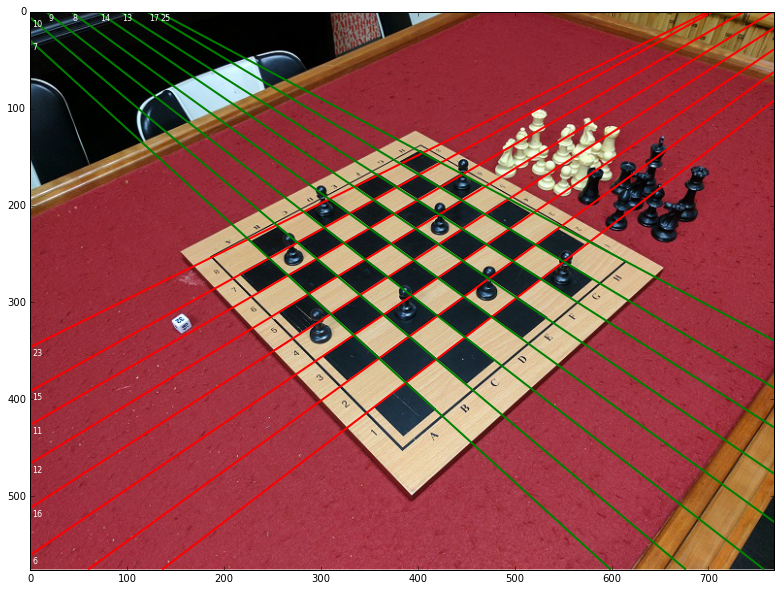

In [196]:
fig = plt.figure(figsize=(30,10))
# subplot(122);
plt.imshow(img_orig);
plt.axis([0,img.shape[1],img.shape[0],0])

colors = 'krgbykrcmykrgbykcmyk'

for k in a_segment_first_7:
    line = lines[k,:]
    x1, y1, x2, y2 = line
    plt.plot([x1,x2], [y1,y2],'%s' % colors[segments[k]], lw=2)
    plt.text(x1+2, y1+9,'%s' % k, color='white', size=8);

for k in b_segment_first_7:
    line = lines[k,:]
    x1, y1, x2, y2 = line
    plt.plot([x1,x2], [y1,y2],'%s' % colors[segments[k]], lw=2)
    plt.text(x1+2, y1+9,'%s' % k, color='white', size=8);

Looking much closer to reality! We need to improve the chess line detection to handle different bimodal frequencies (perhaps using fft) and remove those extraneous lines. There are also redundant lines with slightly different thetas.

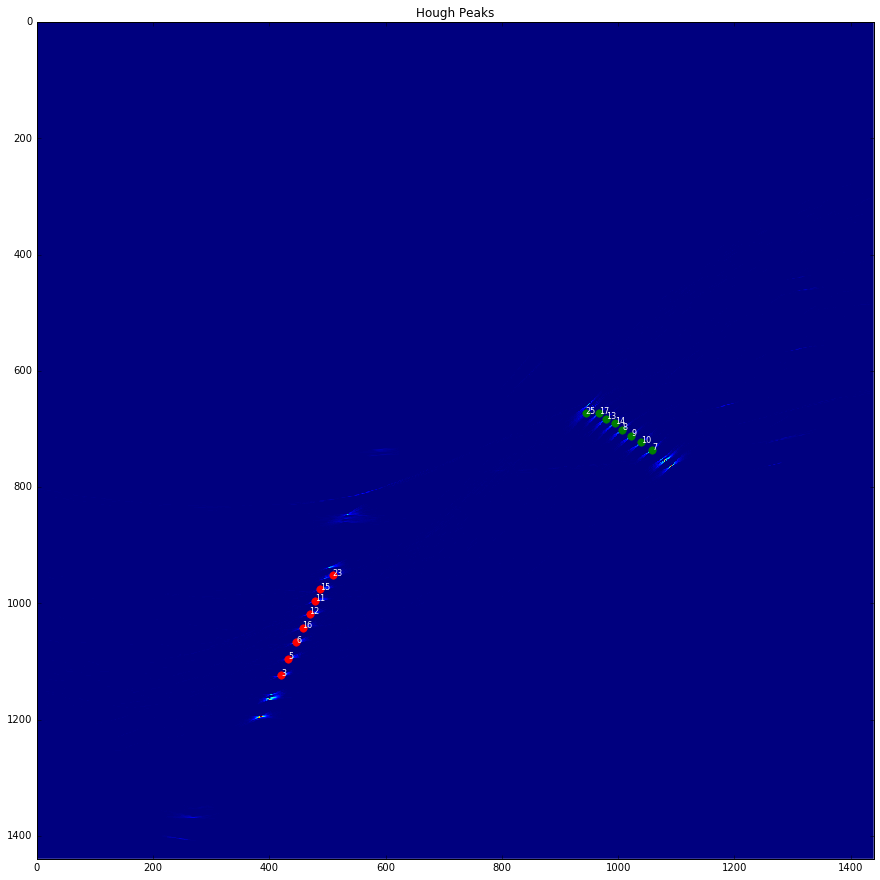

In [197]:
fig = plt.figure(figsize=(15,15))
plt.imshow(input_h.T, interpolation='none')

some_peaks = peaks[:n_peaks,:] # Only first n peaks chosen that are strong enough or up to limit to search

for idx, [px, py] in zip(a_segment_first_7, some_peaks[a_segment_first_7,:]):
    plt.plot(peaks[idx,0], peaks[idx, 1], '.%s' % colors[segments[idx]], ms=15)
    plt.text(px, py,'%s' % idx, color='white', size=8)

for idx, [px, py] in zip(b_segment_first_7, some_peaks[b_segment_first_7,:]):
    plt.plot(peaks[idx,0], peaks[idx, 1], '.%s' % colors[segments[idx]], ms=15)
    plt.text(px, py,'%s' % idx, color='white', size=8)
plt.axis('normal')
plt.axis('tight')
plt.title('Hough Peaks');

# TODO : Prune lines close to each other
Split filtered peaks into two sets, ransac line fit them, this will still have a few bundles of points.
Take the normal distance of each point to the lines, and for any pair of points that are closer than some threshold, choose the point that has a normal distance closer to the line, or that has a stronger peak, or best is a better chessline score.

###  Potential TODO : Use Windows for chessboard hotspot detection

Ways of removing non-chessboard lines

* Take a histogram within a windowed region, and score higher based on if there's 2(4) strong gradients only.
* Remove lines where values along line don't follow canny edges
* histogram of values along line, should be two strong peaks, alternating

# TODO : Computer Vision on tiles to guess color of piece

For each tile calculate:
 * Outer perimeter median color (tile colors)
 * Inner center mean color (piece colors)
 
 Then Do a k-means on outer perimeter for 2 colors, similarly for inner center. Now we have 4 colors, for a given tile we try to see if the outer tile is a darker or lighter tile, and whether the piece is a darker or lighter piece, perhaps comparing piece to tile to try to avoid issues with specularity etc.